# Part 1 - Convolutional Neural Networks for CIFAR-10


In this notebook chapter, we'll build, train and optimize a neural network to classify images of the CIFAR-10 dataset using convolutional neural networks.

This guide uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals


# Import TensorFlow and TensorFlow Datasets
import tensorflow as tf
print(tf.__version__)

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt


from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
# load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
 


class_names = ['airplanes', 'cars', 'birds', 'cats', 'deer',
               'dogs',      'frogs',   'horses',  'ships',   'trucks']
num_classes = len(class_names)


# summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))
y_train_cat = to_categorical(y_train, 10)
y_test_cat  = to_categorical(y_test, 10)
print(y_train.shape)
print(y_test.shape)
print(y_train_cat.shape)
print(y_test_cat.shape)

2.1.0
Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)
(50000, 1)
(10000, 1)
(50000, 10)
(10000, 10)


## 1. Preprocess the data

### 1.1 Zero-Centered Images

The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be zero-centered to the range. So here we compute the mean value per colour channel over all training images and subtract the mean value per colour channel from every image in the training and test set.

In [3]:
train_mean = X_train.mean(axis=(0,1,2))
train_std =  X_train.std(axis=(0,1,2))
print(train_mean)
X_train_zc = X_train - train_mean
X_test_zc  = X_test - train_mean


print(X_train_zc[3].mean(axis=(0,1)))
print(X_train_zc[3].shape)
print(X_train_zc.shape)
print(X_test_zc.shape)
print(X_train_zc.dtype)

[125.3069  122.95015 113.866  ]
[-25.327402 -39.670845 -56.451923]
(32, 32, 3)
(50000, 32, 32, 3)
(10000, 32, 32, 3)
float32


### 1.2 Data Augmentation

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


train_datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False, 
        # set each sample mean to 0
        samplewise_center=False,  
        # divide inputs by std of the dataset
        featurewise_std_normalization=False, 
        # divide each input by its std
        samplewise_std_normalization=False,  
        # apply ZCA whitening
        zca_whitening=False, 
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,  
        # randomly rotate images in the range (degrees, 0 to 180)
        rotation_range=0,  
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0., 
        # set range for random zoom
        zoom_range=0.,  
        # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        channel_shift_range=0.,  
        # value used for fill_mode = "constant"
        fill_mode='nearest',
        cval=0.,  
        # randomly flip images
        horizontal_flip=True, 
        # randomly flip images
        vertical_flip=False,  
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

validation_datagen = ImageDataGenerator( 
      # rescale the pixel values (between 0 and 255) to the [0,1] interval 
      # rescale=1./255
)


## 2. Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### 2.1 Define the network

The basic building block of a neural network is the *layer*. A layer extracts a representation from the data fed into it. Hopefully, a series of connected layers results in a representation that is meaningful for the problem at hand.

Much of deep learning consists of chaining together simple layers. Most layers, like `tf.keras.layers.Dense`, have internal parameters which are adjusted ("learned") during training.

In [5]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train_zc.shape[1:]))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv2D(32, (3, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('softmax'))

`tf.keras.layers.Conv2D(32, (3, 3)))` implies the following parameter settings:


- `filters` : Integer, the dimensionality of the output space (i.e. the number of output filters in the 
convolution). In this case, the number of filters is $32$.

- `kernel_size` : An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window (receptive field). Can be a single integer to specify the same value for all spatial dimensions. In this 
case, the receptive field of the filters are $3\times3$.

- `strides` : An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. Can be a single integer to specify the same value for all spatial dimensions. Default strides : $(1, 1)$

- `padding`: one of `valid` or `same`. In this case, the size of the output volume won't be changed.

`tf.keras.layers.MaxPooling2D(pool_size=(2, 2))` implies the following parameter settings:

- `pool_size`: integer or tuple of 2 integers, factors by which to downscale (vertical, horizontal). $(2, 2)$ will halve the input in both spatial dimension. If only one integer is specified, the same window length will be used for both dimensions.
- `strides`: Integer, tuple of 2 integers, or `None`. `strides` values. If `None`, it will default to `pool_size`. In this case $(2,2)$.

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0

### 2.2 Compile and Fit the Network

In [7]:
import datetime, os
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Compile Network 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

num_validation_examples = 1000
num_train_examples = 5000


train_iterator = train_datagen.flow(X_train_zc[num_validation_examples:num_train_examples], 
                                    y_train_cat[num_validation_examples:num_train_examples], 
                                    batch_size=32)
validation_iterator = validation_datagen.flow(X_train_zc[:num_validation_examples:], 
                                              y_train_cat[:num_validation_examples:], 
                                              batch_size=32)

# Fit Network
history = model.fit_generator(generator= train_iterator,  
                              validation_data = validation_iterator, 
                              epochs=100, 
                              steps_per_epoch=len(train_iterator),
                              callbacks=[tensorboard_callback])

# Determine 
model.evaluate

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 125 steps, validate for 32 steps
Epoch 1/100
125/125 [==============================] - 11s 87ms/step - loss: 2.2512 - accuracy: 0.2062 - val_loss: 1.9002 - val_accuracy: 0.3350
Epoch 2/100
125/125 [==============================] - 9s 71ms/step - loss: 1.9459 - accuracy: 0.2895 - val_loss: 1.7895 - val_accuracy: 0.3670
Epoch 3/100
125/125 [==============================] - 9s 69ms/step - loss: 1.8558 - accuracy: 0.3237 - val_loss: 1.7282 - val_accuracy: 0.3870
Epoch 4/100
125/125 [==============================] - 9s 71ms/step - loss: 1.7955 - accuracy: 0.3543 - val_loss: 1.6843 - val_accuracy: 0.4210
Epoch 5/100
125/125 [==============================] - 9s 69ms/step - loss: 1.7510 - accuracy: 0.3750 - val_loss: 1.6127 - val_accuracy: 0.4420
Epoch 6/100
125/125 [==============================] - 9s 72ms/step - loss: 1.7125 - accuracy: 0.3832 - val_lo

<bound method Model.evaluate of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fee2f13a490>>

### 2.3 Evaluate the Network on the test dataset

In [8]:
model.evaluate(X_test_zc, y_test_cat)

10000/10000 [==============================] - 4s 432us/sample - loss: 1.0911 - accuracy: 0.6336


[1.091132074546814, 0.6336]

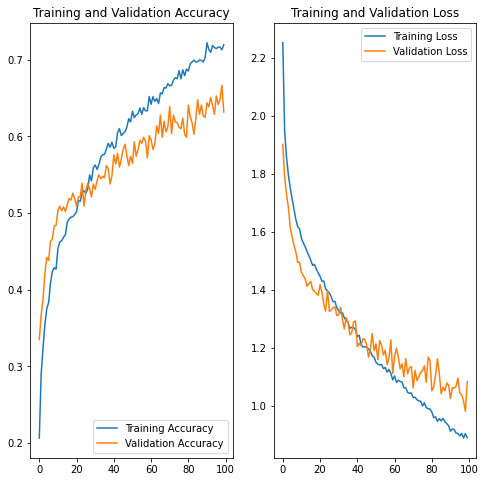

In [9]:
# Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [11]:
os.makedirs(logdir, exist_ok=True)
%tensorboard --logdir logs


### Save the model

In [12]:
model.save('./Daten/cifar_10_convnets_1.h5')

OSError: Unable to create file (unable to open file: name = './Daten/cifar_10_convnets_1.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

# Part 2 - Dogs vs Cats Image Classification : Visualizing what ConvNets learn?

In this notebook chapter, we will discuss how to classify images into pictures of cats or pictures of dogs. We'll build an image classifier using `tf.keras.Sequential` model and load data using `tf.keras.preprocessing.image.ImageDataGenerator`. At the end, we will visualize filters and intermediate activation layers.

## Specific concepts that will be covered:
In the process, we will build practical experience and develop intuition around the following concepts

* Building _data input pipelines_ using the `tf.keras.preprocessing.image.ImageDataGenerator` class — How can we efficiently work with data on disk to interface with our model?
* _Overfitting_ - what is it, how to identify it, and how can we prevent it?
* _Data Augmentation_ and _Dropout_ - Key techniques to fight overfitting in computer vision tasks that we will incorporate into our data pipeline and image classifier model.
* _Visualizing ConvNet filters_
* _Visualizing intermediate activations_


## We will follow the general machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build our model
4. Train our model
5. Test our model
6. Improve our model/Repeat the process

<hr>




## Importing packages

Let's start by importing required packages:

*   os — to read files and directory structure
*   numpy — for some matrix math outside of TensorFlow
*   matplotlib.pyplot — to plot the graph and display images in our training and validation data

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data Loading

To build our image classifier, we begin by downloading the dataset. The dataset we are using is a filtered version of <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Dogs vs. Cats</a> dataset from Kaggle (ultimately, this dataset is provided by Microsoft Research).

In this Jupyter Notebook however, we will make use of the class `tf.keras.preprocessing.image.ImageDataGenerator` which will read data from disk. We therefore need to directly download *Dogs vs. Cats* from a URL and unzip it to your computers filesystem.

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

The dataset we have downloaded has following directory structure.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

We'll now assign variables with the proper file path for the training and validation sets.

In [ ]:
print(os.path.dirname(zip_dir))
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
print(base_dir)
train_dir = os.path.join(base_dir, 'train')
print(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
print(validation_dir)

In [ ]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
print(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
print(train_dogs_dir)
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
print(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures
print(validation_dogs_dir)

### Understanding our data

Let's look at how many cats and dogs images we have in our training and validation directory

In [ ]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [ ]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

# Setting Model Parameters

For convenience, let us set up variables that will be used later while pre-processing our dataset and training our network.

In [ ]:
BATCH_SIZE = 128
IMG_SHAPE  = 150 # Our training data consists of images with width of 150 pixels and height of 150 pixels

After defining our generators for training and validation images, **flow_from_directory** method will load images from the disk and will apply rescaling and will resize them into required dimensions using single line of code.

# Data Augmentation

Overfitting often occurs when we have a small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number and variety of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples through random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This exposes the model to more aspects of the data, allowing it to generalize better.

In **tf.keras** we can implement this using the same **ImageDataGenerator** class we used in the last teaching unit. We can simply pass different transformations we want to our dataset as a form of arguments and it will take care of applying it to the dataset during our training process.

To start off, let's define a function that can display an image, so we can see the type of augmentation that has been performed. Then, we'll look at specific augmentations that we'll use during training.

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### Flipping the image horizontally

We can begin by randomly applying horizontal flip augmentation to our dataset and seeing how individual images will look after the transformation. This is achieved by passing `horizontal_flip=True` as an argument to the `ImageDataGenerator` class.

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

from `IPython.display` import `display`, `ImageTo` see the transformation in action, let's take one sample image from our training set and repeat it five times. The augmentation will be randomly applied (or not) to each repetition.

In [ ]:
from PIL import Image
# if not installed, execute !pip3 install pillow
# then restart kernel
import PIL.Image
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Rotating the image

The rotation augmentation will randomly rotate the image up to a specified number of degrees. Here, we'll set it to 45.

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

To see the transformation in action, let's once again take a sample image from our training set and repeat it. The augmentation will be randomly applied (or not) to each repetition.

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Applying Zoom

We can also apply Zoom augmentation to our dataset, zooming images up to 50% randomly.

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))


One more time, take a sample image from our training set and repeat it. The augmentation will be randomly applied (or not) to each repetition.

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Putting it all together

We can apply all these augmentations, and even others, with just one line of code, by passing the augmentations as arguments with proper values.

Here, we have applied rescale, rotation of 45 degrees, width shift, height shift, horizontal flip, and zoom augmentation to our training images.

In [ ]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Let's visualize how a single image would look like five different times, when we pass these augmentations randomly to our dataset. 

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Creating Validation Data generator

Generally, we only apply data augmentation to our training examples, since the original images should be representative of what our model needs to manage. So, in this case we are only rescaling our validation images and converting them into batches using ImageDataGenerator.

In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

# Model Creation

## Define the model

The model consists of four convolution blocks with a max pool layer in each of them.

Before the final Dense layers, we're also applying a Dropout probability of 0.5. It means that 50% of the values coming into the Dropout layer will be set to zero. This helps to prevent overfitting.

Then we have a fully connected layer with 512 units, with a `relu` activation function. The model will output class probabilities for two classes — dogs and cats — using `softmax`. 

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

### Compiling the model

As usual, we will use the `adam` optimizer. Since we output a softmax categorization, we'll use `sparse_categorical_crossentropy` as the loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Model Summary

Let's look at all the layers of our network using **summary** method.

In [ ]:
model.summary()

### Train the model

It's time we train our network.

Since our batches are coming from a generator (`ImageDataGenerator`), we'll use `fit_generator` instead of `fit`.

In [ ]:
epochs=100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

### Visualizing results of the training

We'll now visualize the results we get after training our network.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Saving the model

In [ ]:
model.save('./Daten/cats_and_dogs_small_1.h5')

# Transfer Learning

In this Notebook Chapter, we'll take a trained model, load it into to Keras, and try it out.

The model that we'll use is VGG16.

In [ ]:
# Defining the loss tensor for filter visualization

model_vgg16 = tf.keras.applications.VGG16(weights='imagenet',
                                   include_top=True)

In [ ]:
model_vgg16.summary()

### Run it on a single image

Remember our `model_vgg16` object is still the full VGG16 model trained on ImageNet, so it has 1000 possible output classes.
ImageNet has a lot of dogs and cats in it, so let's see if it can predict the images in our Dogs vs. Cats dataset.

Next, we we'll get an input image -- a picture of a cat, not part of the images 
the network was trained on. 

In [ ]:
import numpy as np
import PIL.Image as Image

img_path = './Daten/cat_1700.jpg'

from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(224, 224))
img_tensor_orig = image.img_to_array(img)
img_tensor_orig = np.expand_dims(img_tensor_orig, axis=0)
img_tensor =img_tensor_orig/255

print(img_tensor.shape)


### Displaying the test picture

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [ ]:
result = model_vgg16.predict(img_tensor_orig)
result.shape

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax. But how can we know what class this actually is and in particular if that class ID in the ImageNet dataset denotes a cat or something else?

In [ ]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

#### Decode the predictions

To see what our `predicted_class` is in the ImageNet dataset, download the ImageNet labels and fetch the row that the model predicted.

In [ ]:
print(tf.keras.applications.vgg16.decode_predictions(result, top=3))

plt.imshow(img_tensor[0])
plt.axis('off')
predicted_class_name = tf.keras.applications.vgg16.decode_predictions(result, top=1)[0][0][1]
_ = plt.title("Prediction: " + predicted_class_name)

That is not correct. Let us see, whether we can do it better with our model we have trained 
before.

In [ ]:
model = tf.keras.models.load_model('./Daten/cats_and_dogs_small_1.h5')
model.summary()

We first need to resize the photo of the cat to the size $150\times 150$.

In [ ]:
img_path = './Daten/cat_1700.jpg'

from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /=255

print(img_tensor.shape)

In [ ]:
result = model.predict(img_tensor)
print(result)
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

The subdirectory “cat” comes before “dog“, therefore the class labels are assigned the integers: _cat=0, dog=1_. Thus, the prediction is correct.

# Visualizing what convnets learn


It is often said that deep-learning models are "black-boxes" : learning representations that are difficult to extract and present in a human-readable form. Although this is partially true 
for certain types of deep-learning models, it is definitely not true for ConvNets. The representations learned by ConvNets are highly amenable to visualization, in large part because they are _representations of visual concepts_. Since 2013, a wide array of techniques have been developed for visualizing and interpreting these representations. We won't survey all of them, but we will cover three of the most accessible and useful ones:

- _Visualizing intermediate ConvNet outputs (intermediate activations)_ -- Useful for understanding how successive convnet layers transform their input, and for getting a first idea of the meaning of individual ConvNet filters.

- _Visualizing ConvNet filters_ -- Useful for understanding precisely what visual pattern or concept each filter in a convnet is receptive to. 

- _Visualizing heatmaps of class activation in an image_ -- Useful for understanding which parts of an image were identified as belonging to a given class, thus allowing you to localize objects in images.

For the first method - activation visualization - we will use the small ConvNet that we have trained from scratch on the dogs-versus-cats classification problem before. 

## 1. Visualizing intermediate layers

Visualizing intermediate layers consists of displaying the activation maps that are output by various convolution and pooling layers in a network, given a certain input (the output of a layer is often called its __activation maps__, the output of the activation function). 

This gives a view into how an input is decomposed into the different filters learned by the network. You want to 
visualize activation maps with three dimensions: width, height, and depth (number of filters = number of activation maps). Eeach activation map encodes relatively independent features, so the proper way to visualize these activation maps is by independently plotting the contents of every activation map as a 2D image. Lat's start by loading the model that we saved before. 

In [ ]:
model = tf.keras.models.load_model('./Daten/cats_and_dogs_small_1.h5')
model.summary()

Next, we we'll get an input image -- a picture of a cat, not part of the images 
the network was trained on. 

In [ ]:
img_path = './Daten/cat_1700.jpg'

from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /=255

print(img_tensor.shape)

#### Displaying the test picture

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In order to extract the activation maps we want to look at, we will create a Keras model 
that takes batches of images as input, and outputs the activation maps of all convolutional 
and pooling layers. To do this, we will use the Keras class `Model`. 

A model is instantiated using two arguments: an input tensor (or list of input tensors) 
and an output tensor (or list of output tensors). The resulting class is a Keras model, just 
like the `Sequential` models we are familiar with, mapping the specified inputs to the specified outputs. 

What sets the `Model` class apart is that it allows for models with multiple outputs, unlike `Sequential`. 

In [ ]:
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

When fed an image input, this model returns the values of the activation maps in the original 
model. Now we will encounter a multi-output model : until now, 
the models you have seen have had exactly one input and one output. In the general case, a model 
can have any number of inputs and outputs. This one has one input and eight outputs : one output per intermediate layer.

#### Running the model in predict mode

In [ ]:
layer_activation_maps = activation_model.predict(img_tensor)

For instance, this is the output volume of the first convolution layer for the cat image input:

In [ ]:
first_layer_activation_maps = layer_activation_maps[0]
print(first_layer_activation_maps.shape)

It's a 148x148x32 output volume with 32 activation maps. Let's try plotting the first activation map 
of the activation volume of the original model. 

In [ ]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation_maps[0, :, :, 0], cmap='viridis')

This activation map appears to encode a diagonal edge detector. Let's try the seventh activation map of the first layer - 
but note that your own activation maps may vary, because the specific filters learned by convolutional layers 
aren't deterministic.

In [ ]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation_maps[0, :, :, 6], cmap='viridis')

This one looks like a bright white dot detector, useful to encode cat eyes. At this 
point, let's plot a complete visualization of all the activations in the network. 
You will extract and plot every channel in each of the eight activation maps, and you will 
stack the results in one big image tensor, with channels stacked side by side.

In [ ]:
# Visualizing every channel in every intermediate activation

# Names of the layers, so we can 
# have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    

images_per_row = 16

# displays the feature maps
for layer_name, layer_activation in zip(layer_names, layer_activation_maps):
    # number of features in the feature map
    n_features = layer_activation.shape[-1]
    # the feature map has shape (I, size, size, n_features)
    size = layer_activation.shape[1]
    # tiles the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    # tiles each filter into a big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                
                # post-processes the feature to make it visually palatable
                
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
                    
                    
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
                 
                
    
    
    
    
    

There are a few things to note here:

- The first layer acts as a collection of various edge detectors. At that stage, the activations retain almost all of the information present in the initial picture.

- As you go higher, the activations become increasingly abstract and less visually interpretable. They begin to encode higher-level concepts such as "cat ear" and "cat eye". Higher presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image.

- The sparsity of the activations increases with the depth of the layer : in the first layer, all filters are activated by the input image; but in the following layers, more and more filters are blank. This means the pattern encoded by the filter is not found in the input image. 


We have just evidenced an important universal characteristics  of the representations learned by deep neural networks: the features extracted by a layer become increasingly abstract with the depth of the layer. The activations of higher layers carry less and less information about the specific input being seen, and more and more information about the target (in this case, the class fo the image: cat or dog). A deep neural network effectively acts as an _information distillation pipeline_, with raw data going in (in this case, RGB pictures) and being repeatedly transformed so that irrelevant information is magnified and refined (for example, the specific visual appearance of the image), and useful information is magnified and refined (for example, the class of the image).

## 2. Visualizing Convnet Filters

We can access all of the layers of the model via the `model.layers` property.

Each layer has a `layer.name` property, where the convolutional layers have a naming convolution like `block#_conv#`, where the `#` is an integer. Therefore, we can check the name of each layer and skip any that don’t contain the string `conv`.

In [ ]:
# summarize filter shapes
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue

Each convolutional layer has two sets of weights. One is the block of filters and the other is the block of bias values. These are accessible via the `layer.get_weights()` function. We can retrieve these weights and then summarize their shape.

In [ ]:
# get filter weights
filters, biases = layer.get_weights()
print(layer.name, filters.shape)

Tying this together, the complete example of summarizing the model filters is listed below.

In [ ]:
# summarize filters in each convolutional layer
import matplotlib.pyplot as plt
# load the model

# summarize filter shapes
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

We can see that all convolutional layers use 3×3 filters, which are small and perhaps easy to interpret.

We can retrieve the filters from the first layer as follows:

In [ ]:
# retrieve weights from the first hidden layer
filters, biases = model.layers[0].get_weights()
print(filters.shape, biases.shape, filters.dtype)

In [ ]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [ ]:
# plot all 32 filters
n_filters = 32
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    ax = plt.subplot(8, 4 , i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(f)
# show the figure
plt.show()

We can see that for the input image with three channels for red, green and blue, that each filter has a depth of three (here we are working with a channel-last format). We could visualize one filter as a plot with three images, one for each channel, or compress all three down to a single color image, or even just look at the first channel and assume the other channels will look the same. The problem is, we then have 63 other filters that we might like to visualize.


Now we can enumerate the first six filters out of the 32 in the block and plot each of the three channels of each filter.

In [ ]:
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
plt.show()